# Titanic Project

In this project I am working on Kaggle's Titanic dataset. I am using machine learning models to make predictions on the survival of Titanic passengers based upon features such as sex, age and ticket prices. First, I complete some initial data exploration using some typical Pandas tools to get a feel for, and a basic understanding of, the data. I later do more detailed feature engineering such as null value processing, one-hot encoding, and feature scaling. Once the data is processed into training and cross validation data and the models are loaded, the models make predictions which are compared against the true value survival data. The success of these predictions are given by three single valued metrics: accuracy, F1 score and ROC AUC score. These metrics are displayed visually at the bottom of this notebook to display which predictive models worked most successfully. 

This notebook is inspired by work done by others including other Kaggle users, YouTuber Ken Jee, and help from data scientist friends of mine; a particularly special thanks to my close friend Scott Vinay. I understand all code executed below and feel comfortable replicating similar work in future.

### Importing Modules

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.spatial.distance import cdist

import os
import re
from collections import defaultdict

# Sklearn predictive model modules
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

### General Extras

In [2]:
# Useful finder function
def find(s, ch):
    return np.array([i for i, ltr in enumerate(s) if ltr == ch]).astype(int)

In [3]:
# Removing Unnecessary Warnings
pd.options.mode.chained_assignment = None

# Initial Data Exploration and Visualisation

### Basic Dataframe Processing

In the cell below, we do some initial processing of the dataframe. We make all columns lower case and replace any spaces with underscores for easy and consistent referencing. 

We randomly sample the data to ensure theres no order in the raw data. We also set the random number seed to zero to ensure that when we use the load function we get the same dataframe every time. This is particularly important for when we begin our fold rotations later in the notebook, as it ensures that our training and cross validation data have no overlaps for each distinct fold rotation.

To understand fold rotations, imagine the dataframe is separated into 4 quarters: A, B, C, D. The fold rotation is a cyclic permutation of the quarters and allows each quarter to be the cross validation data once. It works as follows: in the first case the quarters A, B, C would be the training data and D would be the cross validation data. Following a single fold B, C, D is now the training data and A is the cross validation. This is repeated until each A, B, C, D quarter is the cross validation data once. 

The modulus operator works well here as it returns the division remainder. When x<y, x%y = x. Once x=y, x%y = 0 and the index list begins growing again from zero. This plays the important role of returning to the A quarter indices once the D quarter indices have been exhausted.

For later requirement of separting our dataframe into training and cross validation data, we create a new column, 'train'. If a row has a train entry of 1, this is training data. If the entry is 0, this is cross validation data.

In [1]:
# Loading data
def load(mode='train', fold=0):   
    """
    Loads dataframe from CSV file and performs initial processing. 
    load does basic processing on the dataframe and it is produced in a certain order depending on the fold
    value. The dataframe can be considered in four quarters and the ordering of the quarters depends on
    the fold value. The permutations of the quarters is always cyclic.
    
    Parameters
    ---------
        fold : int
            By default '0'.
            This value determines the number of fold rotations executed on the dataframe.
            The dataframe is separated into four quarters, so four folds returns the dataframe
            back to it's initial configuration.
        mode : str
            By default 'train'. Options:
            'train': Loads training data.
            'test' : Loads testing data.
    Returns
    -------
        df : DataFrame
            Processed dataframe.
    """
    
    # Loads dataframe as either training or test data
    if mode=='train':
        df = pd.read_csv('data/train.csv')
    elif mode=='test':
        df = pd.read_csv('data/test.csv')
    else:
        raise NotImplementedError
    
    # Initial dataframe processing
    df = df.rename(columns = {c:c.lower().replace(' ', '_') for c in df.columns})
    
    # Creating 'train' column to separate training and validation data
    # Determinstic random shuffling of the data
    np.random.seed(0)
    df = df.sample(frac=1).reset_index(drop=True)
    indices = df.index
    
    # Separating dataframe into 75/25 training to cross validation data
    tr_idx  = indices[:int(len(indices)*0.75)]
    cv_idx  = indices[int(len(indices)*0.75):]
    
    # Apply a fold rotation, to train and cross validate over whole dataframe when producing results
    tr_idx = (tr_idx + int(len(indices)*fold/4))%len(indices)
    cv_idx = (cv_idx + int(len(indices)*fold/4))%len(indices)
    
    # Defining 'train' column
    df.loc[tr_idx, 'train']=1
    df.loc[cv_idx, 'train']=0

    return df

### First Look at The Dataframe

In [5]:
# Loading dataframe
df = load()
df.head()

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,train
0,496,0,3,"Yousseff, Mr. Gerious",male,NaN,0,0,2627,14.4583,NaN,C,1.0
1,649,0,3,"Willey, Mr. Edward",male,NaN,0,0,S.O./P.P. 751,7.5500,NaN,S,1.0
2,279,0,3,"Rice, Master. Eric",male,7.0,4,1,382652,29.1250,NaN,Q,1.0
3,32,1,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,PC 17569,146.5208,B78,C,1.0
4,256,1,3,"Touma, Mrs. Darwis (Hanne Youssef Razi)",female,29.0,0,2,2650,15.2458,NaN,C,1.0


### Data Types and Null Values

In [6]:
# Information on the data types and null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
 12  train        891 non-null    float64
dtypes: float64(3), int64(5), object(5)
memory usage: 90.6+ KB


In [2]:
# Isolating features containing null values
nan_features = []
for c in df.columns:
    if df[c].isnull().values.any(): 
        nan_features.append(c)

# Percentage of NaNs for each column with null values
for nf in nan_features:
    nan_percent = 100*df[nf].isnull().sum()/len(df)
    print('The feature',nf,f'is {nan_percent:.3} percent NaN values')

NameError: name 'df' is not defined

### Numerical Columns Statistics

In [8]:
# Table of the statistical values of the features
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare,train
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,0.749719
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.433418
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,0.500000
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


### Basic Visualisation of Numerical Columns

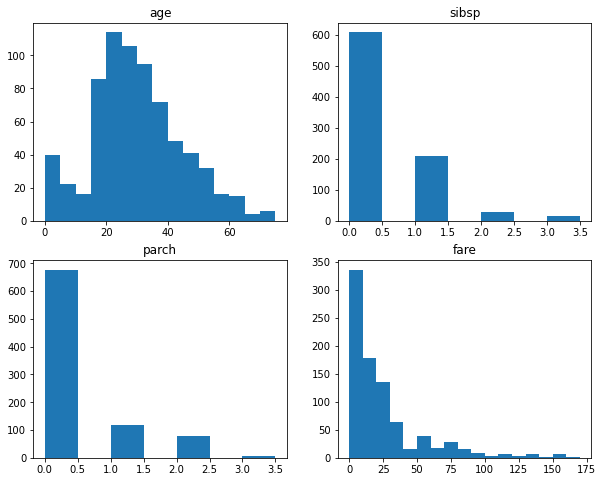

In [9]:
# Separating into numeric and categorical data
num_cols = ['age', 'sibsp', 'parch', 'fare']

# Histogram subplot visualisation of numeric columns
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=[10,8])
axes = axes.flatten()

# Visualisation
count=0
for ax in axes:
    col = num_cols[count]
    bins_=[np.arange(0,80,5), np.arange(0,4,0.5), np.arange(0,4,0.5), np.arange(0,175,10), ]
    ax.hist(df[col],bins=bins_[count])
    ax.set_title(col)
    count+=1
    
# Saving figures
plt.savefig(os.path.join('results', 'numeric_feature_distrib.pdf'),bbox_inches='tight')

Note: Model might be improved to group sibsp and parch by {0, 1+}

# Processing Dataframe

### Function To Sort Null Values

The code below is used to replace the null values. The null evaluation types we have used below are:

1 - Zero: This mode sorts all null values in the dataframe to zero.

2 - Mean: This mode calculates the mean of a column using the training data. Then it applies the mean to all null values in the training and cross validation data.

3 - Nearest Neighbour: This mode makes use of a symmetric 2x2 matrix of distances, that is the distance, or similarity, between each of the rows. The values of the positions (i,j) in our matrix indicate the distance between row i and row j in our dataframe. First, we identify which column in our dataframe contains null values, e.g. column x. Next, we create the distance matrix using all columns except for column x. Now that we have our similarity matrix, we look through column x in our dataframe to find a row, e.g. row y, that contains a null value. We look along row y in the similarity matrix searching for the smallest value, which is given at say position (y,z). Finally, you replace the null value in our dataframe at row y, column x with the value in row z, column x. This process repeats until all null values are replaced with the value in the row that is most similar to itself. 

There are many different metrics to calculate the distance between rows, here below we have used seuclidean which is the standardised euclidean distance. This differs from the regular euclidean distance by standardising the columns before calculating the similarities.

Note: naturally the distance matrix has a trace of zero (zeros along the diagonal) so we have set the diagonal values to purposefully large values to prevent the code from selecting diagonal values as the shortest distance.

In [10]:
# Function to sort the null values 
def fillnull(df, mode = 'zero'):
    """
    Sorts null values of a dataframe.
    fillnull replaces the null values depending on the inputted mode. Zero mode:
    all null vales are replaced with zeros. Mean mode: null values in column containing
    null values are replaced with the mean of that column. Near mode: null values are replaced
    with the value of the row that is most similar to itself.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe that contains null values to be sorted.
            
        mode : By default 'zero'. Options:
            'zero': Sorts null values into zeros.
            'mean': Sorts null values using the mean.
            'near': Sorts null values using the nearest neighbour algorithm.
    Returns
    -------
        df : DataFrame
            Dataframe with no null values.
    """
    if mode=='zero':
        df = df.fillna(0)

    if mode=='mean':
        # Mean of the nf column in training dataframe (don't use cv dataframe as this fits data to cv data)
        mean      = df.loc[df['train']==1, 'age'].mean()
        df['age'] = df['age'].fillna(mean)

    # Using nearest neighbours to sort null values
    if mode=='near':
        df_cols = ['sex', 'sibsp', 'parch', 'fare', 'embarked_C', 'embarked_Q',
                   'embarked_S', 'pclass_1', 'pclass_2', 'pclass_3']

        # Creating distance matrix to find nearest neighbours
        dists   = cdist(df[df_cols].values, df[df_cols].values, 'seuclidean')
        dists   = dists + 1e5*np.identity(dists.shape[0])
        
        # Locates indices of null values
        null_idx     = df.loc[pd.isna(df['age']), :].index
        non_null_idx = df.loc[~pd.isna(df['age']), :].index

        # Loops through rows containing null values
        for i in null_idx:
            # Distances
            distances = list(dists[i, :])
            distance_idx_sorted = sorted(
                                  range(len(distances)), 
                                  key=lambda j: distances[j])
            for k in distance_idx_sorted:
                if np.isnan(df.loc[k, 'age']) == True:
                    continue
                else:
                    df.loc[i, 'age'] = df.loc[k, 'age']
                    break 
    return df

### Processing Function

The process function below formats our features to allow our machine learning models to make predictions on the data.

We converted the 'sex' column of male,female into 1,0.

To make the fare distribution more uniform we take the logarithm of the 'fare' column.

We noticed that the age of people with master as their title was lower than the dataframe mean age. We isolated the ages containing master in the title, calculated their mean and replaced the null values in this subset with this mean.

We one-hot encoded the columns 'embarked' and 'pclass'. This separates these individual columns into n columns, where n is the number of unique values in each column. E.g. the 'pclass' column had entries {1, 2, 3} depending on the ticket class the individual had. After one-hot encoding there are three separate columns: 'pclass_1', 'pclass_2' and 'pclass_3'. In a row where originally 'pclass' = 2, now the new colums have entries: 'pclass_1' = 0, 'pclass_2' = 1, 'pclass_3' = 0.

Next, we make use of the fillnull function above to take any null values left remaining in the processed dataframe to be replaced. This allows us to use all the rows in the data to make predictions. 

In [11]:
# Processing the dataframe
def process(df, fillnull_mode='zero'):
    """
    This function processes the dataframe into a format required for predictive models.
    process performs feature engineering and separates the dataframe into training and cross validation.
    The processed training and cross validation data is returned in a dataframe, alongside the features
    these dataframes contain.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe that requires processing.
            
        fillnull_mode : By default 'zero'. Options:
            'zero': Sorts null values into zeros.
            'mean': Sorts null values using the mean.
            'near': Sorts null values using the nearest neighbour algorithm
                    on the rows.
    Returns
    -------
        dftr : DataFrame
            Training dataframe, used to train the predictive model.
        dfcv : DataFrame
            Cross validation dataframe, used to make and compare predictions
            to test success of predictive models.
        features : list of strings.
            The columns in the training and cross validation dataframe.
    """
    
    # Sorting gender column
    if 'male' in list(df['sex'].values):
        df['sex'] = (df['sex']=='male').astype(int).values
        
    # Taking the logarithm of the fare column to make the distribution more uniform
    df['fare'] = np.log(df.fare+1)
    
    # Sorting age null values using entries in name col containing str 'Master' 
    masterAge_mean = df['age'].loc[df['name'].str.contains('Master')].mean()
    masterAge_mean = round(masterAge_mean, 2)
    df['age'].loc[df['name'].str.contains('Master')] = df['age'].loc[df['name'].str.contains('Master')].fillna(masterAge_mean)
    df.loc[df['name'].str.contains('Master'), 'age'] = df.loc[df['name'].str.contains('Master'), 'age'].fillna(masterAge_mean)
    
    # One-hot encoding 'embarked', 'pclass' columns
    # Embarked column
    df.dropna(subset=['embarked'])
    df_embarked   = pd.get_dummies(df.embarked)
    embarked_cols = list(df_embarked.columns)
    df_embarked = df_embarked.rename(columns = {c: f'embarked_{c}' for c in embarked_cols})
    
    # pclass column
    df_pclass   = pd.get_dummies(df.pclass)
    pclass_cols = list(df_pclass.columns)
    df_pclass   = df_pclass.rename(columns = {c: f'pclass_{c}' for c in pclass_cols})

    # Removing unnecessary columns
    removed_cols = ['name','ticket','embarked','pclass','cabin', 'cabin_number','survived']
    df = pd.concat([df, df_embarked, df_pclass], axis=1)
    
    # Defining dataframe columns
    cols = [c for c in df if c not in removed_cols]
    if 'survived' in df.columns: cols = cols + ['survived']
    df = df[cols]
    
    # Sorting null values using fillnull
    df = fillnull(df, fillnull_mode)
    
    # Feature scaling: normalisation
    for nf in num_cols:
        col = df.loc[df['train']==1, nf]
        num_col_mean = col.mean()
        num_col_std  = col.std()
        df[nf] = (df[nf] - num_col_mean)/num_col_std
        
    # Separating into training and cross validation data
    dftr = df[df['train']==1]
    dfcv = df[df['train']==0]
    
    # Removing 'train' column
    df = df.drop(columns = ['train'])
    
    return dftr, dfcv

# Loading Dataframes and Defining Models

### Loading Data

In [12]:
def get_data_modes(df, features):
    """
    This function loads data for the different modes.
    get_data_modes makes use of the process function which processes the data and separates it into
    training and cross validation data. The X data is stored in a dictionary, which is returned alongside
    the y training and cross validation data.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe we are loading data from.
    Returns
    -------
        X_modes : dict
            Dictionary containing X data for different modes of null evaluation types.
        ytr : array
            y training data.
        ycv : array
            y cross validation data.
    """
    # Training and cross validation data and features
    dftr_near, dfcv_near = process(df, fillnull_mode = 'near')
    dftr_mean, dfcv_mean = process(df, fillnull_mode = 'mean')
    dftr_zero, dfcv_zero = process(df, fillnull_mode = 'zero')

    # X training data
    Xtr_near = dftr_near[features].values
    Xtr_mean = dftr_mean[features].values
    Xtr_zero = dftr_zero[features].values
    # X cross validation data
    Xcv_near = dfcv_near[features].values
    Xcv_mean = dfcv_mean[features].values
    Xcv_zero = dfcv_zero[features].values

    # X data dictionary
    X_modes = {
        'Near': [Xtr_near, Xcv_near],
        'Mean': [Xtr_mean, Xcv_mean],
        'Zero': [Xtr_zero, Xcv_zero]}

    # y outputs (dftr_mean=dftr_zero and dfcv_mean=dfcv_zero as these values aren't changed by sorting null values)
    ytr = dftr_mean['survived'].values
    ycv = dfcv_mean['survived'].values

    return X_modes, ytr, ycv

In [13]:
# Defining our features
features = ['sex', 'age', 'sibsp', 'parch', 'fare', 'embarked_C', 'embarked_Q', 'embarked_S', 'pclass_1', 'pclass_2', 'pclass_3']

# Defining our data
X_modes, ytr, ycv = get_data_modes(df, features)

### Defining the Predictive Models

In [14]:
# Creating models
model_rf = RandomForestClassifier()
model_gb = GradientBoostingClassifier()
model_lr = LogisticRegression(max_iter=1e5)

# Models dictionary
models = {
    'Random Forest': model_rf,
    'Gradient Boosting': model_gb,
    'Logistic Regression': model_lr}

# Results

### Get Result Function

The get_results function produces the metric results using the various different models, which indicates how well the models do when predicting the outcome on the cross validation set. The models are first created using the training data, (Xtr, ytr), and then they use the cross validation input data, Xcv, to determine the probabilities of the outcomes, y_prob. These probabilities are used to calculate the outcome predictions, y_pred, which here is predicting whether or not a passenger survived. These probabilities, y_prob, and predictions, y_pred, are then compared directly to the true cross validation output data, ycv, and return a single value metric that allows easy comparison between the different models and null evaluation modes. The there metrics we have used below are the accuracy, F1 score and ROC AUC score.

In [15]:
def get_results(models, X_modes, ytr, ycv):
    """
    Produces the metric results that allow for comparison of models and modes.
    get_results loops through each combination of model and mode, calculates the output
    probabilities and predictions, and produces metric results in a  results dataframe.
    
    Parameters
    ---------
        models : dict
            Dictionary containing predictive models.
        X_modes : dict
            Dictionary containing input training and cross validation
            data for different null evaluation types.
        ytr : numpy.ndarray
            Array containing output training data.
        ycv : numpy.ndarray
            Array containing output cross validation data.
    Returns
    -------
        df_results : DataFrame
            Dataframe containing the results for the models
            and data inputted.
    """
    
    # Creating empty dictionary
    data = defaultdict(list)
    
    # Looping through each model
    for m in models.keys():
        model      = models[m]
        # Looping through each set of X data
        for x in X_modes.keys():
            # Fitting model to X,y training data
            X = X_modes[x][0]
            y = ytr
            model.fit(X,y)
            
            # y prediction using cross validation data
            y_pred       = model.predict(X_modes[x][1])
            y_total_prob = model.predict_proba(X_modes[x][1])
            y_prob       = y_total_prob[:,1]
            
            # Evaluation metrics
            acc = accuracy_score(y_pred,ycv)
            f1  = f1_score(y_pred,ycv)
            roc = roc_auc_score(ycv, y_prob)
            
            # Appending values to dataframe
            data['model'   ].append(m)
            data['mode'    ].append(x)
            data['accuracy'].append(acc)
            data['f1'      ].append(f1)
            data['roc_auc' ].append(roc)
            
            # Creating dataframe of results
            df_results = pd.DataFrame(data)
            
    return df_results

### Results Dataframe

In [16]:
# Dataframe of models, null evaluation types and metric scores
df_results = get_results(models, X_modes, ytr, ycv)
df_results

,model,mode,accuracy,f1,roc_auc
0,Random Forest,Near,0.798206,0.730539,0.860422
1,Random Forest,Mean,0.811659,0.758621,0.856782
2,Random Forest,Zero,0.802691,0.750000,0.865633
3,Gradient Boosting,Near,0.820628,0.753086,0.881183
4,Gradient Boosting,Mean,0.829596,0.765432,0.884698
5,Gradient Boosting,Zero,0.834081,0.773006,0.864020
6,Logistic Regression,Near,0.820628,0.761905,0.901737
7,Logistic Regression,Mean,0.825112,0.766467,0.901902
8,Logistic Regression,Zero,0.816143,0.748466,0.897270


### Best Result Function

This function searches the results dataframe above to extract the metric score, along with the optimum model and mode, so that it doesn't have to do be done manually. It searches one of the metric columns, finds the maximum value and the index at which the maximum value occurs. It then uses the index to extract the model and mode that correspond to that maximum value.

In [17]:
def finding_best_results(df_results, metric):
    """
    Finds the best score for the specified metric, along with the model and mode corresponding to it,
    in the results dataframe.
    finding_best_results searches the result dataframe to find the maximum value in the specified 
    metric column. It then uses the index of the maximum value to cross reference the corresponding 
    model and mode. These three values are returned by the function.
    
    Parameters
    ---------
        df_results : DataFrame
            Dataframe of results.
        metric : str
            By default 'f1'. Options:
                'f1' : F1 score.
                'accuracy' : accuracy score.
                'roc_auc' : ROC AUC score.
    Returns
    -------
        best_model : str
            Model corresponding to metrics highest score.
        best_mode : str
            Mode corresponding to metrics highest score.
        best_score : str
            Best score 
    """
    # Finding the best score in the results table
    best_score = df_results[metric].max()
    idx        = df_results[metric].idxmax()
    best_model = df_results.loc[idx, 'model']
    best_mode  = df_results.loc[idx, 'mode']
    
    return best_model, best_mode, best_score

### Displaying Best Results

In [18]:
def display_results(df_results):
    """
    Prints the best score for the specific metric, along with the model and mode corresponding to it,
    found in the dataframe.
    display_results uses the finding_best_results function to print the best score and it's
    corresponding model and mode.
    
    Parameters
    ---------
        df_results : DataFrame
            Dataframe of results.
    Returns
    -------
        best_model : str
            Model corresponding to metrics highest score.
        best_mode : str
            Mode corresponding to metrics highest score.
        best_score : str
            Best score 
    """
    # Finding best results
    best_acc = finding_best_results(df_results, 'accuracy')
    best_f1  = finding_best_results(df_results, 'f1')
    best_roc = finding_best_results(df_results, 'roc_auc')
    
    # Defining metrics and best score lists
    metric = ['accuracy', 'f1', 'roc_auc']
    best_metric = [best_acc, best_f1, best_roc]

    # Displaying results
    for i in range(len(metric)):
        print(f'Best {metric[i]} score: {best_metric[i][2]:.3f} \nAchieved using {best_metric[i][0]} and "{best_metric[i][1]}" null evaluation type.\n')

In [19]:
# Printing results
display_results(df_results)

Best accuracy score: 0.834 
Achieved using Gradient Boosting and "Zero" null evaluation type.

Best f1 score: 0.773 
Achieved using Gradient Boosting and "Zero" null evaluation type.

Best roc_auc score: 0.902 
Achieved using Logistic Regression and "Mean" null evaluation type.



# Visualising Results

The plotter function recieves the results dataframe and plots them in an easily understood bar chat. The models are separated by spaces and the different null value evaluation types are colours. This function can include error bars if the dataframe contains the right columns required for doing so.

In [20]:
def plotter(df, metric='f1', save=False):
    """
    Plots the results of a results dataframe.
    plotter loops through each combination of model and mode in our results dataframe, and
    plots the results in a bar chart. If the results dataframe includes the mean and std columns,
    we also plot the errors associated with that metric. In this case, the data is the mean of total
    results which is calculated by averaging the results of the four fold rotations, and the error is 
    the standard deviation.
    
    Parameters
    ---------
        df : DataFrame
            Dataframe of results.
        metric : str
            By default 'f1'. Options:
                'accuracy' : accuracy score.
                'f1' : F1 score.
                'roc_auc' : ROC AUC score.
    Returns
    -------
    
    """
    # General figure configuration
    plt.figure(figsize=(10,5))
    sns.set(font_scale=2)
    
    # Creating lists from dataframe
    models         = sorted(df['model'].unique())
    nan_eval_types = sorted(df['mode'].unique())
    
    # Model separation on graphs
    main_ticks = np.arange(len(models))
    jump = 1/(len(nan_eval_types)+1)
    
    # Looping through each null value evaluation type
    for i, net in enumerate(nan_eval_types):
        # Spacing between models
        xpos = main_ticks + jump*i
        
        # If we are including error calculation for error bars
        if metric+'_std' in df.columns:
            plot_data = [df.loc[(df['model']==mod) &
                            (df['mode']==net),
                            metric+'_mean'].values[0] for mod in models]
            # Error data
            err_data = [df.loc[(df_results['model']==mod) &
                            (df['mode']==net),
                            metric+'_std'].values[0] for mod in models]
            plt.bar(
                xpos,
                plot_data,
                yerr = err_data,
                width = jump*0.9,
                label = net.title(),
                capsize=12)

        # If error data not included
        else:
            plot_data = [df.loc[(df['model']==mod) &
                                (df['mode']==net),
                                metric].values[0] for mod in models]

            # Plotting bar charts
            plt.bar(xpos,
                   plot_data,
                   width = jump*0.9,
                   label = net.title())
    
    # Customisation with more specifc customisation depending on metric used
    if metric == 'f1':
        plt.ylabel(r'$F_1$ Score')
        plt.title(r'Titanic: $F_1$ Scores')
    if metric == 'accuracy':
        plt.ylabel('Accuracy Score')
        plt.title('Titanic: Accuracy Scores')
    if metric == 'roc_auc':
        plt.ylabel('ROC AUC Score')
        plt.title('Titanic: ROC AUC Score')
    # Spacing between different models
    plt.gca().set_xticks(main_ticks + jump*(i/2))
    
    # Legend 
    legend = plt.legend(title='Null Value Processing Type', loc=[1.01,0.50])
    plt.setp(legend.get_title(), fontsize=14)
    
    # Limits
    met_min = df_results[metric].min()
    met_max = df_results[metric].max()
    buffer  = (met_max - met_min)*2
    plt.ylim([met_min - buffer, met_max + buffer])
    
    # General
    plt.gca().set_xticklabels([m.replace(' ', '\n') for m in models])
    plt.grid(axis='x')
    
    if save == True:
        plt.savefig(os.path.join('results',f'{metric}_results.png'),bbox_inches='tight')
    
    plt.show()

### Visualising Final Results Using Bar Graphs

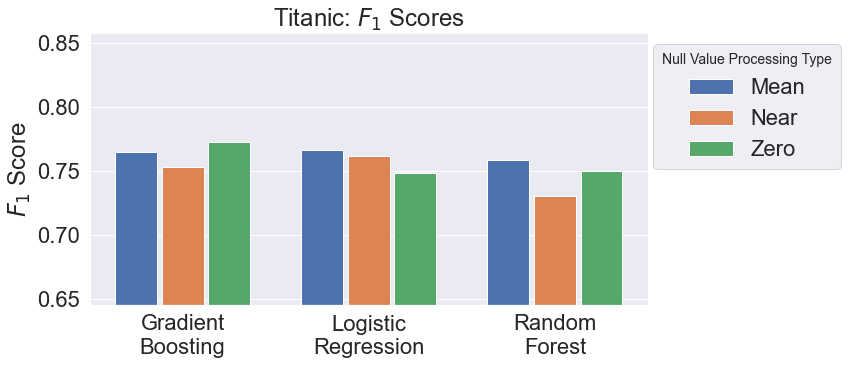

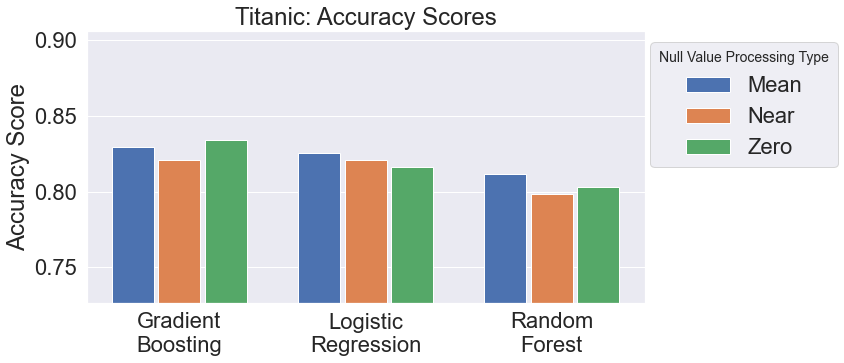

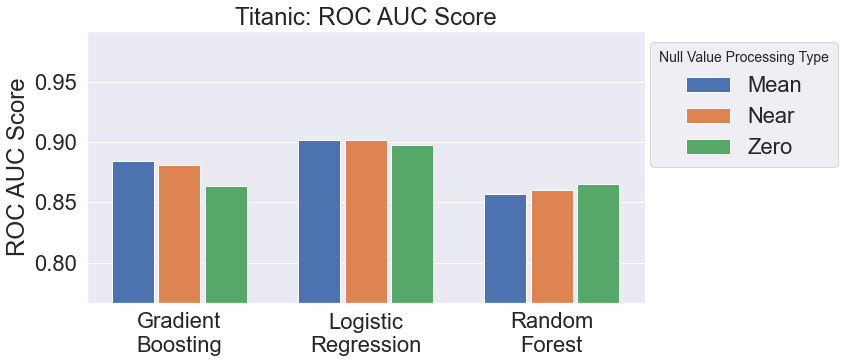

In [21]:
# Plotting results for each separate metric
plotter(df_results)
plotter(df_results, metric='accuracy')
plotter(df_results, metric='roc_auc')

# Error bars

To account for the possibility of getting 'easy' training and cross validation data that could display better results than are true, we have quartered the dataframe and then varied the rotational fold to collect the quarters together with different cyclic permutations, as described at the top of this notebook before the load function. An empty list, results_all, is created and recieves an appended dataframe for each of the four rotational folds that the dataframe experiences. Once completed, these dataframes are concatenated together to created one data frame with all the different models, null evaluation types and metric scores.

Next, the dataframe is grouped by model and mode, taking the mean and standard deviation of the accuracy and f1 scores and creating new columns for these values. The mean value is represented as the height of the bar charts and the standard deviation is represented using the error bar.

In [22]:
# Creating a dataframe of results for each different fold rotation
results_all = []
for fold in [0,1,2,3]:
    # Creating new variation of dataframe
    df = load(fold=fold)
    
    # Loading training and cross validation data 
    X_modes, ytr, ycv = get_data_modes(df, features)
    
    # Calculating results and creating 'fold' column to indicate which rotation the results are associated with
    df_results = get_results(models, X_modes, ytr, ycv)
    df_results['fold'] = fold
    
    # Appending results dataframe
    results_all.append(df_results)
# Combining all data into one dataframe
results_all = pd.concat(results_all)

# Grouping by model and mode, taking the mean and std of the metrics within each group.
results_all = results_all.groupby(['model','mode'])[['accuracy','f1','roc_auc']].agg({'accuracy':['mean','std'], 'f1':['mean','std'], 'roc_auc':['mean','std']}).reset_index(drop=False)
results_all.columns = results_all.columns.map('_'.join)

# Removing underscores from column names that don't require them
results_all = results_all.rename(columns={
    'model_':'model',
    'mode_':'mode'
    })

### Visualising Results With Error Bars

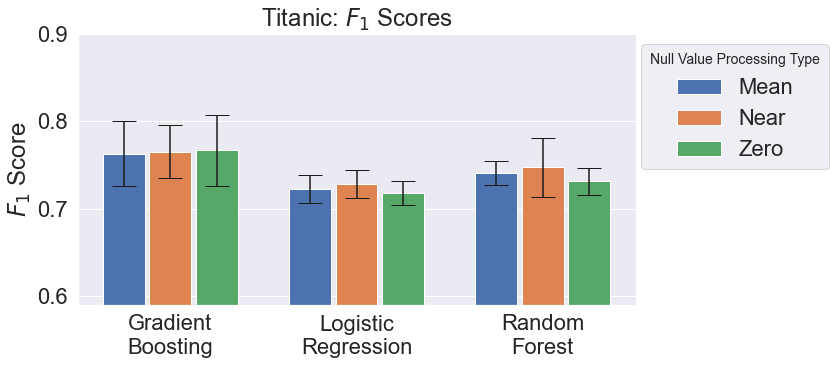

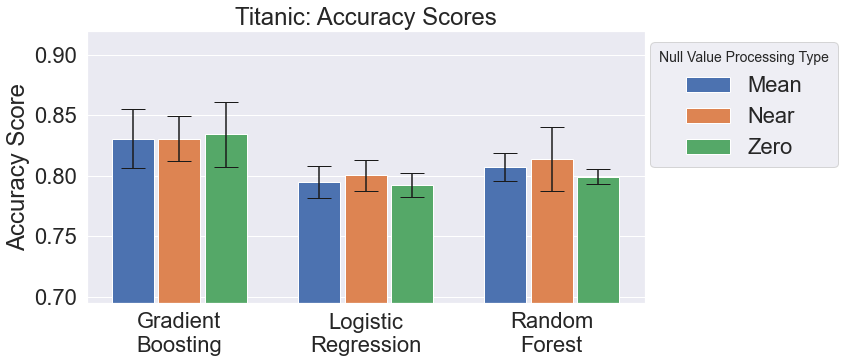

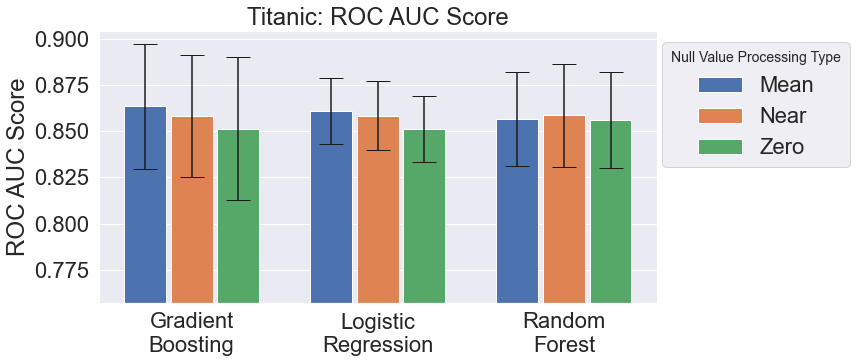

In [23]:
# Plotting results for each separate metric, now with error bars
plotter(results_all, metric='f1', save=True)
plotter(results_all, metric='accuracy', save=True)
plotter(results_all, metric='roc_auc', save=True)

# Predictions

Now that I am confident in my choice of mode and model, I am going to submit my work to Kaggle to be scored. First we load the test and train dataframes and process them using the same method as above. Now that we want our model to predict on the X data given in the test dataframe, we can use the entirety of the train dataframe to train our model. We go ahead and do this, training our model using our train dataframe and using the data in the test dataframe to make our predictions. These predictions alongside the passenger index, 'passengerid', are written to a CSV file and submitted to Kaggle's Titanic page. 

In [24]:
# # Loading the dataframes
# df_train = load(mode='train')
# df_test  = load(mode='test')

# # Processing the dataframes
# # Training data
# dftr, dfcv = process(df_train)
# df_train = pd.concat([dftr, dfcv]).reset_index(drop=True)
# # Test data
# dftr, dfcv = process(df_test)
# df_test = pd.concat([dftr, dfcv]).reset_index(drop=True)

# # Separating into X,y data
# Xtr = df_train[features].values
# ytr = df_train['survived'].values
# Xtest = df_test[features].values

# # Fitting the data
# model_gb.fit(Xtr, ytr)

# # Predictions for the test data
# test_pred = model_gb.predict(Xtest)

# # Submission dataframe
# passenger_idx = df_test['passengerid']
# df_submission = pd.DataFrame(np.c_[passenger_idx, test_pred], columns = ['PassengerId','Survived'])

# # Converting to CSV file
# df_submission.to_csv('titanic_submission', encoding='utf-8', index=False)